# run this first

In [ ]:
! sbatch_tail -p gpu -q gpu --gres=gpu:A100:4 --cpus-per-task 20 --mem-per-gpu 80G --ntasks-per-node=4 slurm/submit.sh "predict --config config/base_v3.yml --scprint_training.noise [0.7,1.0] --scprint_training.mask_ratio [] --model.dropout 0 --data.num_workers 17 --data.force_recompute_indices True --data.weight_scaler 0 --data.test_split 0 --data.batch_size 120 --trainer.num_nodes 1 --model.expr_emb_style metacell --data.get_knn_cells True --data.metacell_mode 0 --model.expr_encoder_layers 1 --model.compress_class_dim \"{'cell_type_ontology_term_id':64,'tissue_ontology_term_id':32,'disease_ontology_term_id':32,'age_group':8,'assay_ontology_term_id':12,'self_reported_ethnicity_ontology_term_id':8,'sex_ontology_term_id':2,'organism_ontology_term_id':8,'cell_culture':2}\" --model.layers_cls [256] --ckpt_path /pasteur/zeus/projets/p02/ml4ig_hot/Users/jkalfon/scprint_v2/czg34ita/checkpoints/last.ckpt"

In [ ]:
# set this at the beginning of model.py's _predict() function
self.keep_all_labels_pred = True
self.mask_zeros = True

NameError: name 'self' is not defined

In [ ]:
# to know to be able to work with these embeddings:
model.classes
model.hparams["classes"](counts)
num = {
    "cell_type_ontology_term_id": 3,
    "tissue_ontology_term_id": 3,
    "disease_ontology_term_id": 3,
    "age_group": 3,
    "assay_ontology_term_id": 3,
    "self_reported_ethnicity_ontology_term_id": 3,
    "sex_ontology_term_id": 1,
    "organism_ontology_term_id": 3,
    "cell_culture": 1,
}

In [ ]:
# replace the log_adata of model.py with this if you are going to generate data for hundreds of millions of cells (adata is not gonna work well)
def log_adata(self, gtclass=None, name=""):
    """
    log_adata will log an adata from predictions.
    It will log to tensorboard and wandb if available

    see @utils.log_adata
    """
    try:
        mdir = self.logger.save_dir if self.logger.save_dir is not None else "/tmp"
    except:
        mdir = "data/"
    mdir = "/pasteur/appa/scratch/jkalfon/" + mdir
    if not os.path.exists(mdir):
        os.makedirs(mdir)
    self.embs = (
        torch.concat([v for k, v in self.embs.items()], dim=1)
        .cpu()
        .numpy()
        .astype(np.float16)
    )

    count = {
        "cell_type_ontology_term_id": 3,
        "tissue_ontology_term_id": 3,
        "disease_ontology_term_id": 3,
        "age_group": 3,
        "assay_ontology_term_id": 3,
        "self_reported_ethnicity_ontology_term_id": 3,
        "sex_ontology_term_id": 1,
        "organism_ontology_term_id": 3,
        "cell_culture": 1,
    }
    tot = 0
    locs = []
    predloc = []
    for val in self.classes:
        num = self.hparams["classes"][val]
        pred_slice = self.pred[:, tot : tot + num]
        loc = pred_slice.argsort(-1)[:, -count[val] :].flip([-1])
        top_k = torch.gather(pred_slice, 1, loc)
        predloc.append(top_k.cpu().numpy().astype(np.float16))
        locs.append(loc.cpu().numpy().astype(np.uint16))
        tot += num

    predloc = np.hstack(predloc)
    locs = np.hstack(locs)
    save = (
        str(mdir)
        + "/step_"
        + str(self.global_step)
        + "_"
        + str(self.name)
        + "_"
        + str(name)
        + "_"
        + str(self.global_rank)
    )
    np.savez(save + "_top3", locs)
    np.savez(save + "_scores", predloc)
    np.savez(save + "_embs", self.embs)

### re-group your data

In [ ]:
import os
from umap_pytorch import load_pumap
from umap_pytorch import PUMAP

import json
from scdataloader.utils import translate
from sklearn.metrics.pairwise import cosine_similarity
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
%reload_ext autoreload
%autoreload 2

In [ ]:
embs = []
scores = []
cl = []
LOC = "/pasteur/appa/scratch/jkalfon/full_emb/"  # ".45050971./../"
for i in os.listdir(LOC):
    if i.startswith("step_0__predict_part_") and i.endswith("_embs.npz"):
        embs.append(np.load(LOC + i)["arr_0"])
    if i.startswith("step_0__predict_part_") and i.endswith("_scores.npz"):
        scores.append(np.load(LOC + i)["arr_0"])
    if i.startswith("step_0__predict_part_") and i.endswith("_top3.npz"):
        cl.append(np.load(LOC + i)["arr_0"])
    break
embs = np.vstack(embs)
scores = np.vstack(scores)
cl = np.vstack(cl)
cl.shape

### you can analyze the relationships between predictions

In [ ]:
with open("/pasteur/appa/scratch/jkalfon/label_decoders.json", "r") as f:
    decoders = json.load(f)

In [ ]:
decoders["organism_ontology_term_id"]

{'0': 'NCBITaxon:10090',
 '1': 'NCBITaxon:10181',
 '2': 'NCBITaxon:3702',
 '3': 'NCBITaxon:4577',
 '4': 'NCBITaxon:6239',
 '5': 'NCBITaxon:7227',
 '6': 'NCBITaxon:7955',
 '7': 'NCBITaxon:9031',
 '8': 'NCBITaxon:9483',
 '9': 'NCBITaxon:9544',
 '10': 'NCBITaxon:9598',
 '11': 'NCBITaxon:9606',
 '12': 'NCBITaxon:9823',
 '13': 'NCBITaxon:9913',
 '14': 'NCBITaxon:9940',
 '15': 'NCBITaxon:9986'}

In [ ]:
res = translate(
    set(decoders["self_reported_ethnicity_ontology_term_id"].values()),
    "self_reported_ethnicity_ontology_term_id",
)
res

{'HANCESTRO:0588': 'Jewish Israeli',
 'HANCESTRO:0383': 'Irish',
 'HANCESTRO:0485': 'Bangladeshi',
 'HANCESTRO:0018': 'uncategorised population',
 'HANCESTRO:0439': 'Iraqi',
 'HANCESTRO:0321': 'Finnish',
 'HANCESTRO:0005,HANCESTRO:0008': 'European,Asian',
 'HANCESTRO:0013,HANCESTRO:0014': 'Native American,Hispanic or Latin American',
 'HANCESTRO:0019': 'Japanese',
 'HANCESTRO:0598': 'Singaporean Indian',
 'HANCESTRO:0005': 'European',
 'HANCESTRO:0007': 'South East Asian',
 'HANCESTRO:0574': 'Pacific Islander',
 'HANCESTRO:0021': 'Chinese',
 'HANCESTRO:0590': 'European American',
 'HANCESTRO:0013': 'Native American',
 'HANCESTRO:0004': 'ancestry category',
 'HANCESTRO:0566': 'undefined ancestry population',
 'HANCESTRO:0487': 'Indian',
 'HANCESTRO:0017': 'Oceanian',
 'HANCESTRO:0008': 'Asian',
 'HANCESTRO:0015': 'Greater Middle Eastern  (Middle Eastern or North African or Persian)',
 'HANCESTRO:0568': 'African American',
 'HANCESTRO:0022': 'Korean',
 'HANCESTRO:0027': 'Han Chinese',
 '

In [ ]:
# Create a contingency table (matrix) where rows are unique values from col -8
# and columns are unique values from col -7, with values being the counts.
matrix_counts = pd.crosstab(cl[:, -4], cl[:, -3])
matrix_counts

col_0,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15
row_0,,,,,,,,,,,,,,,,
0,0,0,8,1,2,111,0,1,0,9338,0,6142274,0,0,0,14
1,0,0,0,22,11420,0,0,0,0,0,0,8,0,0,14836,0
2,0,0,0,154,4168,0,5,4,553,646,87508,0,0,0,477,0
3,0,613,174,0,6,0,0,0,12,0,18376,3,0,0,823,0
4,0,1,700,0,0,0,0,14493,0,0,0,0,0,0,0,0
5,0,0,0,0,93390,0,0,1,0,0,0,0,0,0,0,0
6,0,0,1,1,0,26425,0,2005,0,0,1,5,0,158602,0,1
7,0,0,1,0,6576,0,27218,0,0,0,1,0,2439,0,0,0
8,0,0,52,178,0,0,0,0,0,5834,912,0,4,103,1,7


In [ ]:
matrix_counts = (matrix_counts.T / (1 + matrix_counts.sum(axis=1)).values).T

In [ ]:
res = translate(
    set(decoders["organism_ontology_term_id"].values()),
    "organism_ontology_term_id",
)

In [ ]:
matrix_counts.index = [
    res[decoders["organism_ontology_term_id"][str(i)]] for i in matrix_counts.index
]
matrix_counts.columns = [
    res[decoders["organism_ontology_term_id"][str(i)]] for i in matrix_counts.columns
]

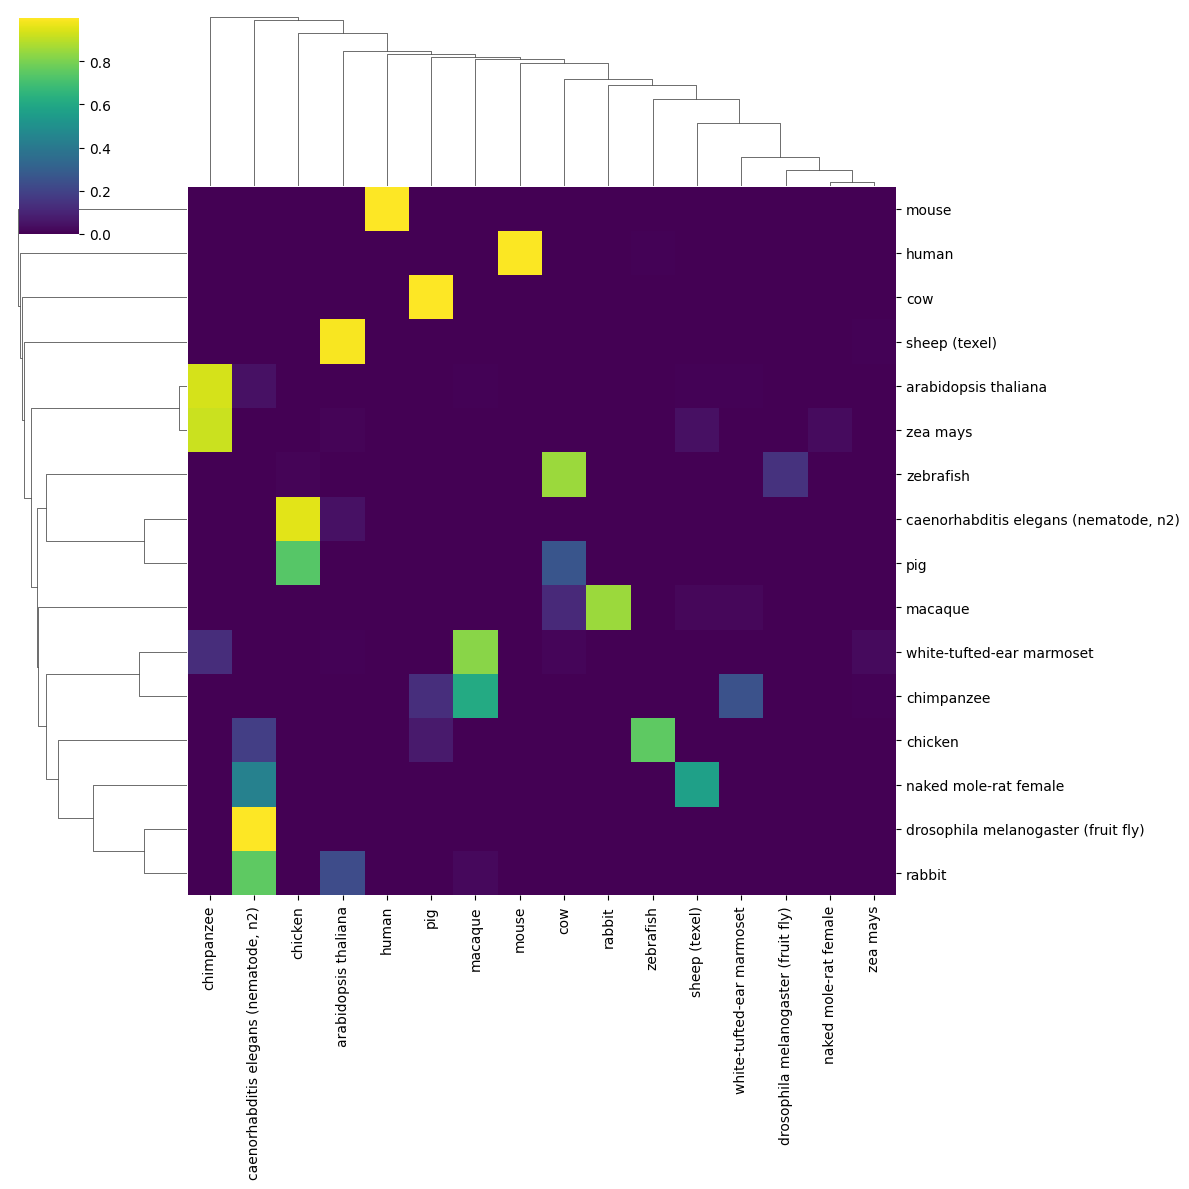

In [ ]:
# Plot using clustermap
sns.clustermap(matrix_counts, cmap="viridis", figsize=(12, 12))
plt.show()

### you can compute a parametric umap for millions of cells

In [ ]:
pumap = PUMAP(
    n_neighbors=10,
    min_dist=0.1,
    metric="euclidean",
    n_components=2,
    beta=1.0,  # How much to weigh reconstruction loss for decoder
    # reconstruction_loss=F.binary_cross_entropy_with_logits, # pass in custom reconstruction loss functions
    random_state=None,
    lr=1e-3,
    epochs=10,
    batch_size=64,
    num_workers=1,
    num_gpus=1,
    match_nonparametric_umap=False,  # Train network to match embeddings from non parametric umap
)

pumap.fit(embs[:2_000_000, 256 : 256 + 64])

💡 Tip: For seamless cloud uploads and versioning, try installing [litmodels](https://pypi.org/project/litmodels/) to enable LitModelCheckpoint, which syncs automatically with the Lightning model registry.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
/pasteur/appa/homes/jkalfon/scPRINT/.venv/lib/python3.11/site-packages/pytorch_lightning/trainer/connectors/logger_connector/logger_connector.py:76: Starting from v1.9.0, `tensorboardX` has been removed as a dependency of the `pytorch_lightning` package, due to potential conflicts with other packages in the ML ecosystem. For this reason, `logger=True` will use `CSVLogger` as the default logger, unless the `tensorboard` or `tensorboardX` packages are found. Please `pip install lightning[extra]` or one of them to enable TensorBoard support by default


Sat Nov 22 17:26:58 2025 Building RP forest with 76 trees
Sat Nov 22 17:27:47 2025 NN descent for 21 iterations
	 1  /  21
	 2  /  21
	 3  /  21
	Stopping threshold met -- exiting after 3 iterations


: 

: 

: 

In [ ]:
embedding = pumap.transform(torch.Tensor(embs[:, 256 : 256 + 64]))  # (50000, 2)

Reducing array of shape torch.Size([20040, 64]) to (20040, 2)


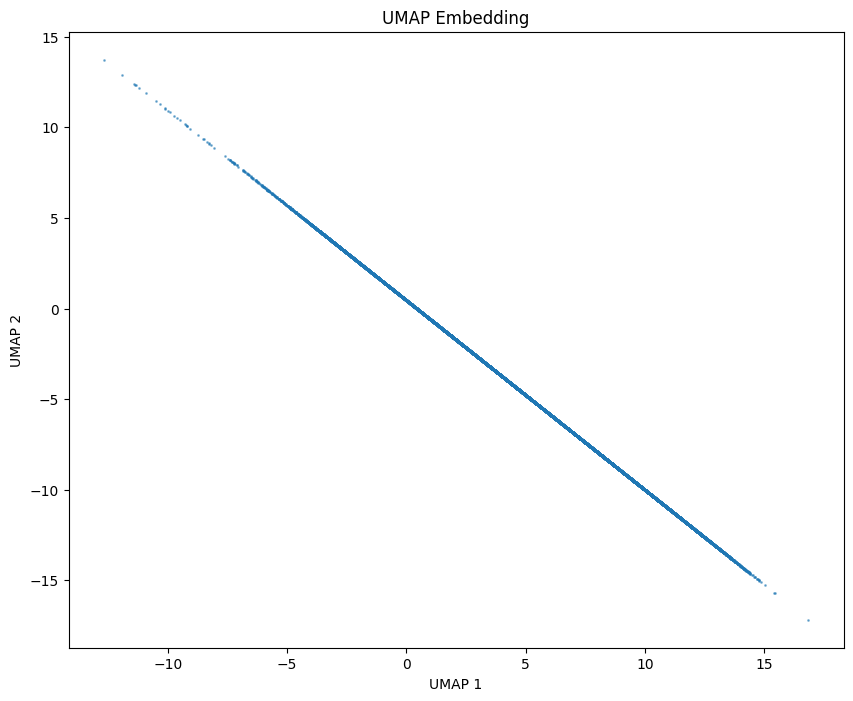

In [ ]:
plt.figure(figsize=(10, 8))
plt.scatter(embedding[:, 0], embedding[:, 1], s=1, alpha=0.5)
plt.xlabel("UMAP 1")
plt.ylabel("UMAP 2")
plt.title("UMAP Embedding")
plt.show()

## otherwise: 

you can always use scprint as is and merge all of its adata using this function (it will also compute a general umap for all data combined):

In [ ]:
srun -p ml4ig -c 32 --mem 90G python figures/niceumap.py

In [ ]:
data_directory = "/pasteur/appa/scratch/jkalfon/45322258/"
name = "18hebyht"

In [ ]:
adata = sc.read_h5ad(data_directory + name + "_predict.h5ad")  # , backed="r")
adata

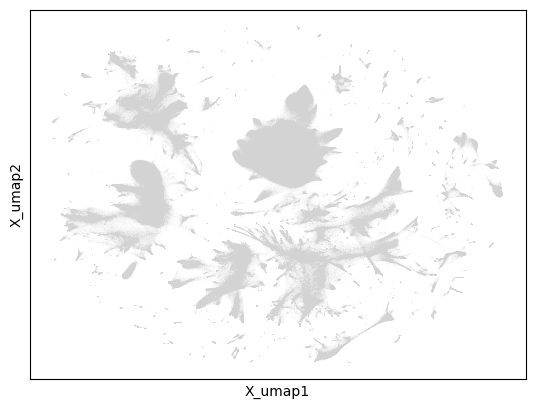

In [ ]:
sc.pl.embedding(adata[:1_500_000], "X_umap")

/pasteur/appa/homes/jkalfon/scPRINT/.venv/lib/python3.11/site-packages/scanpy/plotting/_utils.py:465: ImplicitModificationWarning: Trying to modify attribute `._uns` of view, initializing view as actual.
  adata.uns[f"{value_to_plot}_colors"] = colors_list


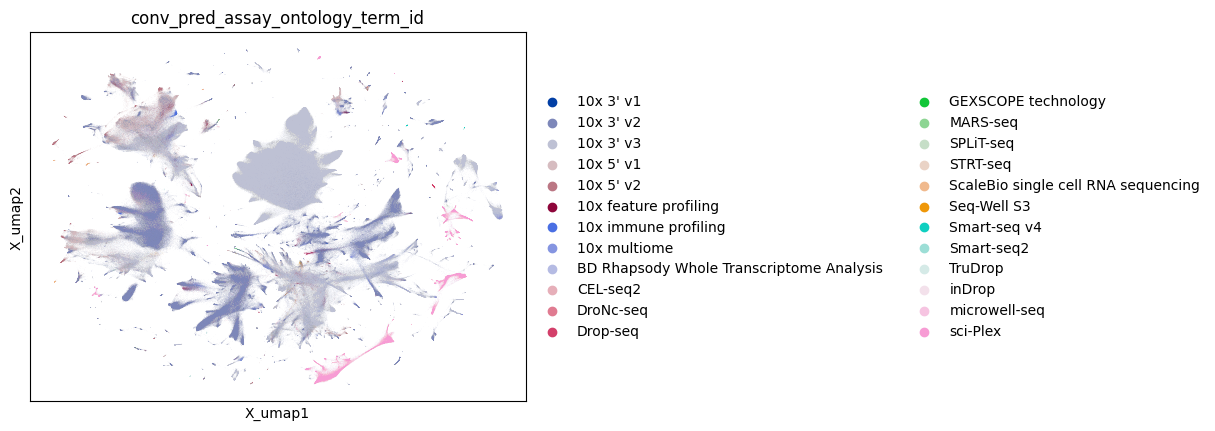

In [ ]:
sc.pl.embedding(adata[:2000000], "X_umap", color="conv_pred_assay_ontology_term_id")

/pasteur/appa/homes/jkalfon/scPRINT/.venv/lib/python3.11/site-packages/scanpy/plotting/_utils.py:465: ImplicitModificationWarning: Trying to modify attribute `._uns` of view, initializing view as actual.
  adata.uns[f"{value_to_plot}_colors"] = colors_list


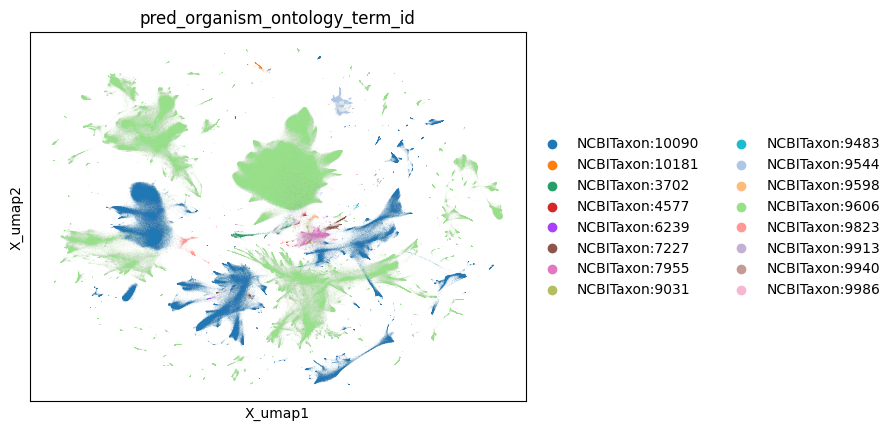

In [ ]:
sc.pl.embedding(adata[:2000000], "X_umap", color="pred_organism_ontology_term_id")

/pasteur/appa/homes/jkalfon/scPRINT/.venv/lib/python3.11/site-packages/scanpy/plotting/_utils.py:465: ImplicitModificationWarning: Trying to modify attribute `._uns` of view, initializing view as actual.
  adata.uns[f"{value_to_plot}_colors"] = colors_list


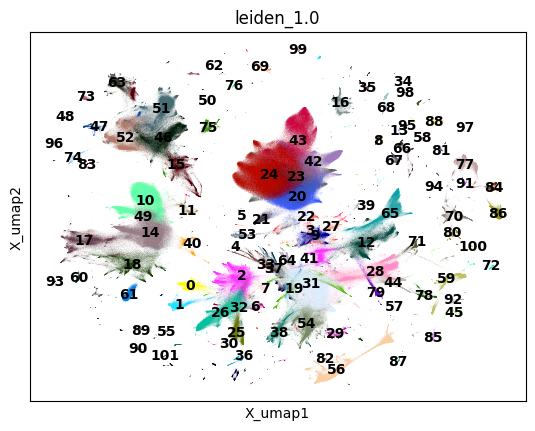

In [ ]:
sc.pl.embedding(adata[:2000_000], "X_umap", color="leiden_1.0", legend_loc="on data")

# then you can create nice interactive umaps

In [1]:
from scdataloader.utils import translate
import scanpy as sc
from anndata.experimental import concat_on_disk
from umap import UMAP
import numpy as np

import bionty as bt
from scdataloader.utils import get_all_ancestors

import matplotlib

import datamapplot

→ connected lamindb: jkobject/scprint2


In [2]:
data_directory = "/pasteur/appa/scratch/jkalfon/45322258/"
name = "18hebyht"

In [3]:
adata = sc.read_h5ad(data_directory + name + "_predict.h5ad")  # , backed="r")
adata

AnnData object with n_obs × n_vars = 16406560 × 0
    obs: 'pred_cell_type_ontology_term_id', 'pred_tissue_ontology_term_id', 'pred_disease_ontology_term_id', 'pred_age_group', 'pred_assay_ontology_term_id', 'pred_self_reported_ethnicity_ontology_term_id', 'pred_sex_ontology_term_id', 'pred_organism_ontology_term_id', 'pred_cell_culture', 'conv_pred_cell_type_ontology_term_id', 'conv_pred_tissue_ontology_term_id', 'conv_pred_disease_ontology_term_id', 'conv_pred_age_group', 'conv_pred_assay_ontology_term_id', 'conv_pred_self_reported_ethnicity_ontology_term_id', 'leiden_1.0'
    uns: 'leiden_1.0', 'neighbors', 'umap'
    obsm: 'X_umap', 'scprint_emb_cell_type_ontology_term_id'
    obsp: 'connectivities', 'distances'

In [4]:
res = {}
subres = {}
for i in [
    "pred_sex_ontology_term_id",
    "pred_cell_culture",
    "pred_organism_ontology_term_id",
    "conv_pred_cell_type_ontology_term_id",
    "conv_pred_self_reported_ethnicity_ontology_term_id",
]:
    print(i)
    res[i] = adata.obs[i].value_counts()
    print(len(res[i]))
    subres[i] = {j: j if k > 150 else "other" for j, k in res[i].items()}
    print(len(set(subres[i].values())))

pred_sex_ontology_term_id


2
2
pred_cell_culture


2
2
pred_organism_ontology_term_id


16
16
conv_pred_cell_type_ontology_term_id


337
254
conv_pred_self_reported_ethnicity_ontology_term_id


16
16


In [5]:
rt = translate(
    res["pred_organism_ontology_term_id"].keys(), "organism_ontology_term_id"
)

In [6]:
rt = {j: rt[i] for i, j in enumerate(res["pred_organism_ontology_term_id"].keys())}

In [7]:
rt["NCBITaxon:9483"] = "marmoset"
rt["NCBITaxon:7227"] = "drosophila"
rt["NCBITaxon:3702"] = "arabidopsis"
rt["NCBITaxon:4577"] = "maize"
rt["NCBITaxon:6239"] = "c. elegans"
rt["NCBITaxon:9940"] = "sheep"

In [8]:
adata.obs["conv_pred_organism_ontology_term_id"] = adata.obs[
    "pred_organism_ontology_term_id"
].replace(rt)

/local/scratch/tmp/ipykernel_4121235/1575082616.py:3: FutureWarning: The behavior of Series.replace (and DataFrame.replace) with CategoricalDtype is deprecated. In a future version, replace will only be used for cases that preserve the categories. To change the categories, use ser.cat.rename_categories instead.
  ].replace(rt)


In [9]:
subsubres = {}
for i in [
    "conv_pred_cell_type_ontology_term_id",
]:
    print(i)
    res[i] = adata.obs[i].value_counts()
    print(len(res[i]))
    subsubres[i] = {j: j if k > 1500 else "other" for j, k in res[i].items()}
    print(len(set(subsubres[i].values())))

conv_pred_cell_type_ontology_term_id


337
183


In [10]:
subres["conv_pred_assay_ontology_term_id"] = {
    "10x 3' v2": "10x 3'",
    "10x 3' v3": "10x 3'",
    "10x 3' v1": "10x 3'",
    "10x immune profiling": "10x 3'",
    "10x multiome": "10x 3'",
    "Smart-seq v4": "Smart-seq",
    "Smart-seq2": "Smart-seq",
    "10x 5' v2": "10x 5'",
    "10x 5' v1": "10x 5'",
}

In [11]:
MAX = 3_500_000

In [12]:
plot = datamapplot.create_interactive_plot(
    adata[:MAX].obsm["X_umap"],
    adata[:MAX].obs["conv_pred_organism_ontology_term_id"],
    adata[:MAX]
    .obs["conv_pred_cell_type_ontology_term_id"]
    .replace(subsubres["conv_pred_cell_type_ontology_term_id"]),
    noise_label="other",
    colormap_rawdata=[
        adata[:MAX]
        .obs["conv_pred_cell_type_ontology_term_id"]
        .replace(subres["conv_pred_cell_type_ontology_term_id"])
        .values,
        adata[:MAX].obs["conv_pred_organism_ontology_term_id"].values,
        adata[:MAX]
        .obs["conv_pred_assay_ontology_term_id"]
        .replace(subres["conv_pred_assay_ontology_term_id"])
        .values,
        adata[:MAX].obs["pred_cell_culture"].values,
    ],
    colormap_metadata=[
        {
            "field": "cell type",
            "description": "Predicted Cell Type",
            "cmap": "gist_rainbow",
            "kind": "categorical",
            "n_colors": len(subres["conv_pred_cell_type_ontology_term_id"]),
            # palete
        },
        # organism
        {
            "field": "organism",
            "description": "Predicted Organism",
            "cmap": "tab20",
            "kind": "categorical",
            "n_colors": len(subres["pred_organism_ontology_term_id"]),
        },
        # assay
        {
            "field": "assay",
            "description": "Predicted Assay",
            "cmap": "tab20",
            "kind": "categorical",
            "n_colors": len(subres["conv_pred_assay_ontology_term_id"]),
        },
        # cell culture
        {
            "field": "culture",
            "description": "Predicted Cellular Culture",
            "cmap": "Set3",
            "kind": "categorical",
            "n_colors": len(subres["pred_cell_culture"]),
        },
    ],
    hover_text=(
        "organism: "
        + adata[:MAX].obs["conv_pred_organism_ontology_term_id"].astype(str)
        + "\ncell type: "
        + adata[:MAX].obs["conv_pred_cell_type_ontology_term_id"].astype(str)
        + "\ncellular culture: "
        + adata[:MAX].obs["pred_cell_culture"].astype(str)
        + "\nassay: "
        + adata[:MAX].obs["conv_pred_assay_ontology_term_id"].astype(str)
        + "\ntissue of origin: "
        + adata[:MAX].obs["conv_pred_tissue_ontology_term_id"].astype(str)
        + "\ndisease of origin: "
        + adata[:MAX].obs["conv_pred_disease_ontology_term_id"].astype(str)
        + "\nage: "
        + adata[:MAX].obs["conv_pred_age_group"].astype(str)
        + "\nsex: "
        + adata[:MAX].obs["pred_sex_ontology_term_id"].astype(str)
        + "\n ethnicity: "
        + adata[:MAX]
        .obs["conv_pred_self_reported_ethnicity_ontology_term_id"]
        .astype(str)
    ),
    font_family="DejaVu Sans",
    # cmap="viridis",
    enable_search=True,
    inline_data=False,
    use_medoids=True,
    initial_zoom_fraction=0.5,
)

/local/scratch/tmp/ipykernel_4121235/2795529706.py:6: FutureWarning: The behavior of Series.replace (and DataFrame.replace) with CategoricalDtype is deprecated. In a future version, replace will only be used for cases that preserve the categories. To change the categories, use ser.cat.rename_categories instead.
  .replace(subsubres["conv_pred_cell_type_ontology_term_id"]),


/local/scratch/tmp/ipykernel_4121235/2795529706.py:11: FutureWarning: The behavior of Series.replace (and DataFrame.replace) with CategoricalDtype is deprecated. In a future version, replace will only be used for cases that preserve the categories. To change the categories, use ser.cat.rename_categories instead.
  .replace(subres["conv_pred_cell_type_ontology_term_id"])


/local/scratch/tmp/ipykernel_4121235/2795529706.py:16: FutureWarning: The behavior of Series.replace (and DataFrame.replace) with CategoricalDtype is deprecated. In a future version, replace will only be used for cases that preserve the categories. To change the categories, use ser.cat.rename_categories instead.
  .replace(subres["conv_pred_assay_ontology_term_id"])


/pasteur/appa/homes/jkalfon/scPRINT/.venv/lib/python3.11/site-packages/sklearn/base.py:1389: ConvergenceWarning: Number of distinct clusters (15) found smaller than n_clusters (337). Possibly due to duplicate points in X.
  return fit_method(estimator, *args, **kwargs)


In [13]:
plot.save("./nice_umap_scprint3.html")